# **Movie Recommendation System**

In [0]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = [14,14]

# **Dataset Content Description**

> The dataset using is collected from Flixable( third-party Netflix search engine) which consists of TV Shows and Movies available on Netflix.
Responsibilities:

*  Exploring what type of content is available in different countries.
*   Identifying similar content of Tv shows and movies by matching text-based features.

*   Network analysis of Directors or Actors.

## **Load the data**

In [0]:
df = pd.read_csv(r'netflix.csv')
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0,[],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0,[],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


In [0]:
print(df.shape)

(6234, 19)


# Data Investigation

In [0]:
def data_inv(df):
    print('netflix movies and shows: ',df.shape[0])
    print('dataset variables: ',df.shape[1])
    print('-'*10)
    print('dateset columns: \n')
    print(df.columns)
    print('-'*10)
    print('data-type of each column: \n')
    print(df.dtypes)
    print('-'*10)
    print('missing rows in each column: \n')
    c=df.isnull().sum()
    print(c[c>0])
data_inv(df)

netflix movies and shows:  6234
dataset variables:  19
----------
dateset columns: 

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year', 'month', 'day', 'directors', 'categories', 'actors',
       'countries'],
      dtype='object')
----------
data-type of each column: 

show_id                  int64
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year                   float64
month                  float64
day                    float64
directors               object
categories              object
actors                  object
countries               object
dtype: object
---------

# **Data Analysis**

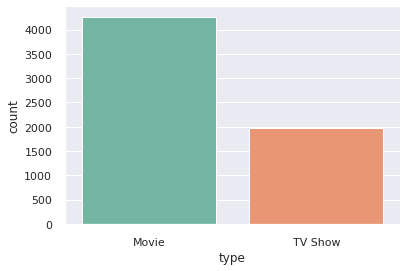

In [0]:
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=df, palette="Set2")

UR and NR is the same rating(unrated,Not rated)

> We fix this problem by replace UR category by NR.







In [0]:
for i in df.index:
    if df.loc[i,'rating']=='UR':
        df.loc[i,'rating']='NR'

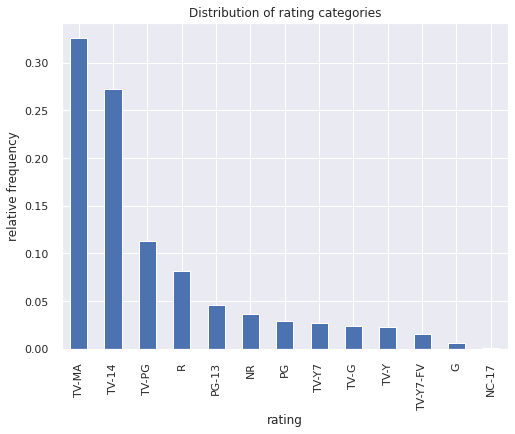

In [0]:
plt.figure(figsize=(8,6))
df['rating'].value_counts(normalize=True).plot.bar()
plt.title('Distribution of rating categories')
plt.xlabel('rating')
plt.ylabel('relative frequency')
plt.show()

The distribution of rating ctegories,

> TV-MA takes highest mode, 
TV-14 comes in the second place and so on



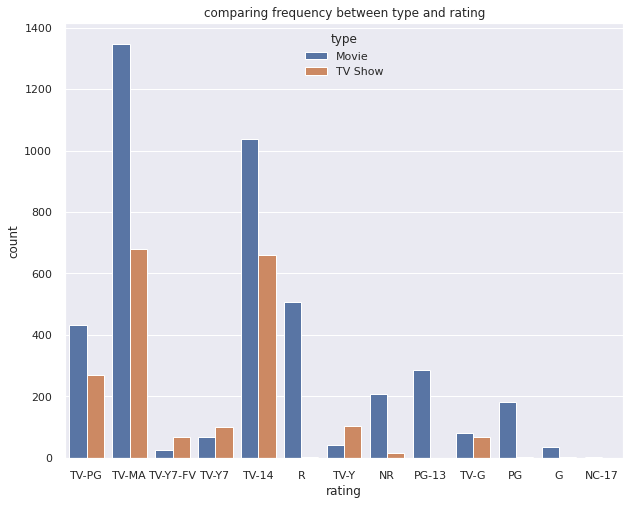

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(x='rating',hue='type',data=df)
plt.title('comparing frequency between type and rating')
plt.show()

We can say that Movies is the majority category in every rating distribution category on Netflix, except(TV-Y,TV-Y7,TV-Y7-FV).

In [0]:
df['country'].value_counts().sort_values(ascending=False)

United States                             2032
India                                      777
United Kingdom                             348
Japan                                      176
Canada                                     141
                                          ... 
United States, South Korea                   1
New Zealand, United Kingdom, Australia       1
United States, Canada, Germany               1
Norway, Germany, Sweden                      1
Iran, France                                 1
Name: country, Length: 554, dtype: int64

we have huge number of countries in country column,
so we will focus on 
* United States, India, United Kingdom, Japan, Canada,Spain.



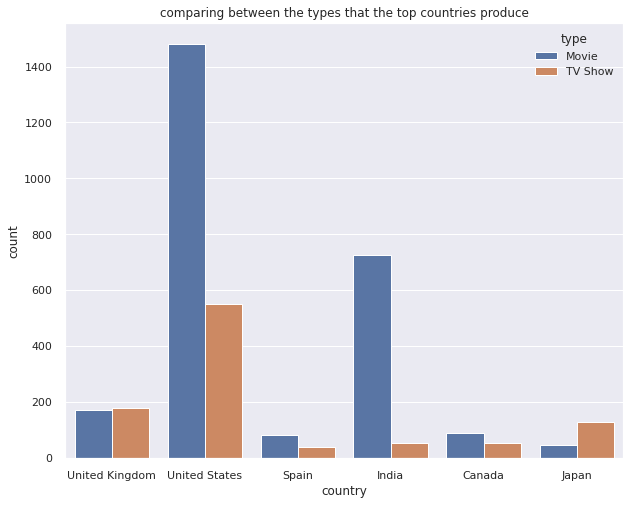

In [0]:
top_productive_countries=df[(df['country']=='United States')|(df['country']=='India')|(df['country']=='United Kingdom')|(df['country']=='Japan')|
                             (df['country']=='Canada')|(df['country']=='Spain')]
plt.figure(figsize=(10,8))
sns.countplot(x='country',hue='type',data=top_productive_countries)
plt.title('comparing between the types that the top countries produce')
plt.show()

UK and Japan produces TV-Shows more than Movies

In [0]:
for i in top_productive_countries['country'].unique():
    print(i)
    print(top_productive_countries[top_productive_countries['country']==i]['rating'].value_counts(normalize=True)*100)
    print('-'*10)

United Kingdom
TV-MA       39.942529
TV-14       23.275862
TV-PG       17.816092
R            7.471264
TV-G         6.034483
NR           2.298851
PG           0.862069
TV-Y7        0.862069
TV-Y         0.574713
TV-Y7-FV     0.287356
G            0.287356
PG-13        0.287356
Name: rating, dtype: float64
----------
United States
TV-MA       30.704781
TV-14       16.707738
R           13.405619
TV-PG       10.399211
PG-13        8.279941
PG           5.027107
NR           4.534253
TV-G         3.006407
TV-Y7        2.562839
TV-Y7-FV     2.069985
TV-Y         1.971414
G            1.281419
NC-17        0.049285
Name: rating, dtype: float64
----------
Spain
TV-MA    65.811966
TV-14    18.803419
NR        6.837607
TV-PG     3.418803
R         1.709402
PG        1.709402
TV-Y      0.854701
TV-G      0.854701
Name: rating, dtype: float64
----------
India
TV-14       54.182754
TV-MA       23.423423
TV-PG       16.731017
NR           2.574003
TV-G         0.900901
TV-Y7        0.643501
PG-13

In [0]:
dups=df.duplicated(['title'])
df[dups]['title']

378                                     Maniac
843                                     Tunnel
1066                                      Love
1361                                     Drive
1597                                   Manhunt
                         ...                  
5930                                 Kakegurui
5978                                  Hostages
6026                                  Lovesick
6159                                     Skins
6231    Little Baby Bum: Nursery Rhyme Friends
Name: title, Length: 62, dtype: object

The above titles have one or more contents.

In [0]:
for i in df[dups]['title'].values:
    print(df[df['title']==i][['title','type','release_year','country']])
    print('-'*40)

      title     type  release_year        country
150  Maniac  TV Show          2018  United States
378  Maniac  TV Show          2015         Norway
----------------------------------------
       title     type  release_year      country
477   Tunnel  TV Show          2019          NaN
843   Tunnel  TV Show          2017  South Korea
2498  Tunnel    Movie          2016  South Korea
----------------------------------------
     title     type  release_year          country
19    Love    Movie          2015  France, Belgium
1066  Love    Movie          2008        Indonesia
5825  Love  TV Show          2018    United States
----------------------------------------
      title   type  release_year        country
1249  Drive  Movie          2011  United States
1361  Drive  Movie          2019          India
----------------------------------------
        title     type  release_year           country
182   Manhunt  TV Show          2017     United States
1597  Manhunt    Movie          

**Netflix Genre in countries**

In [0]:
from collections import Counter
genre = df['listed_in']
genre_count = pd.Series(dict(Counter(','.join(genre).replace(' ,',',').replace(', ',',')
                                       .split(',')))).sort_values(ascending=False)

genre_count

International Movies            1927
Dramas                          1623
Comedies                        1113
International TV Shows          1001
Documentaries                    668
TV Dramas                        599
Action & Adventure               597
Independent Movies               552
TV Comedies                      436
Thrillers                        392
Children & Family Movies         378
Romantic Movies                  376
Crime TV Shows                   363
Kids' TV                         328
Stand-Up Comedy                  281
Docuseries                       279
Romantic TV Shows                278
Horror Movies                    262
Music & Musicals                 243
British TV Shows                 210
Sci-Fi & Fantasy                 193
Sports Movies                    157
Reality TV                       153
Korean TV Shows                  132
TV Action & Adventure            126
Anime Series                     117
Spanish-Language TV Shows        117
C

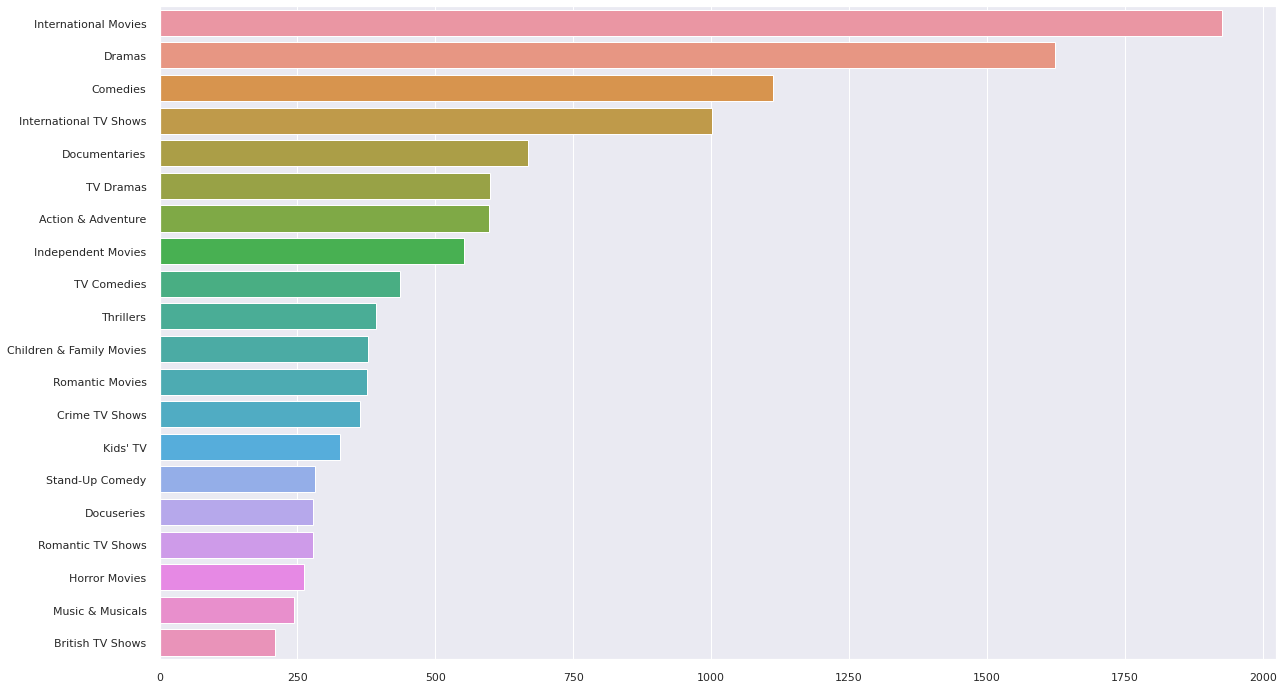

In [0]:
genre_top = genre_count[:20]
plt.figure(figsize=(20,12))
sns.barplot(genre_top, genre_top.index)
plt.show()

# **KMeans clustering with TF-IDF**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 
    
request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head()

10     5899
49       61
103       9
46        6
52        5
Name: cluster, dtype: int64

 tfidf will be used in order to find similar description

In [0]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

  
# **Load the graph (undirected graph)**
Nodes:


> Movies

> Person

> Categories

> country

> Cluster (description)

> Similar(title) top 5 similar movies based on description
## Edges are :

* ACTED_IN : relation between an actor and a movie

* CAT_IN : relation between a categories and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description


Two movies are not directly connected, but they share persons, categories,clusters and countries.

In [0]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
        indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))   

 iter 0 -- 0.051348209381103516 seconds --
 iter 1000 -- 4.941716909408569 seconds --
 iter 2000 -- 9.708633422851562 seconds --
 iter 3000 -- 14.717931985855103 seconds --
 iter 4000 -- 20.02624249458313 seconds --
 iter 5000 -- 24.967538118362427 seconds --
 iter 6000 -- 29.994284868240356 seconds --
 finish -- 31.17080783843994 seconds --


# The recommendation function

* Explore the neighborhood of the target film/movie/TV show → this is a list of actor,
director, country, categories
* Explore the neighborhood of each neighbor → discover the film/movies/TV shows
that share a node with the target field
* Calculate Adamic Adar measure → final results

In [0]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

In [0]:
result = get_recommendation("Transformers Prime")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Transformers Prime'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Transformers Prime'
****************************************
Transformers: Robots in Disguise    3.613282
Beyond Skyline                      1.801518
Spirit: Riding Free                 1.742503
Chappaquiddick                      1.645837
Would You Rather                    1.569881
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.575565
Ocean's Eleven       2.100704
The Departed         1.698527
Brooklyn's Finest    1.492545
Boyka: Undisputed    1.400020
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Devil and Father Amorth              1.423117
Making a Murderer                        1.243407
Belief: The Possession of Janet Moses    1.116221
The Diabolical                           1.032475
The Autopsy of Jane Doe               

A sub-graph with only two movies .

In [0]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

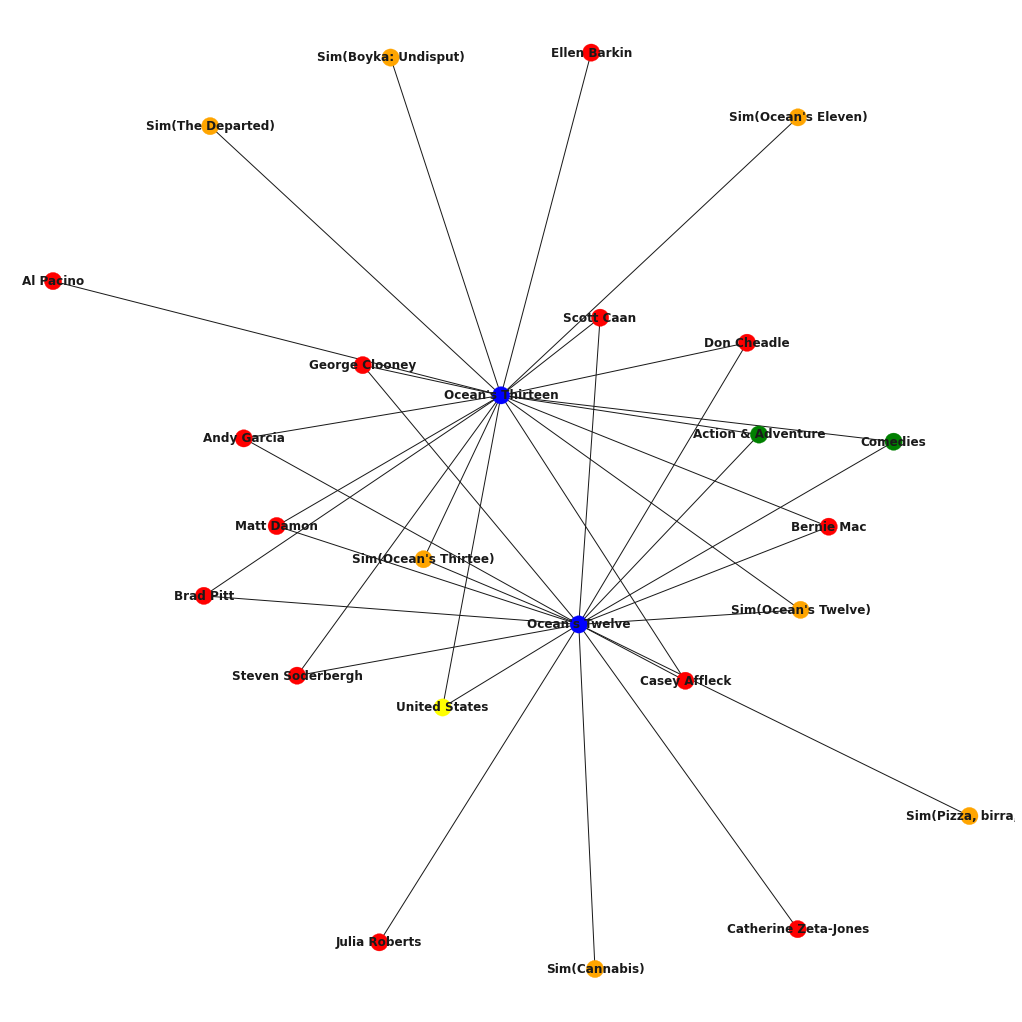

In [0]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

 Draw top recommendations



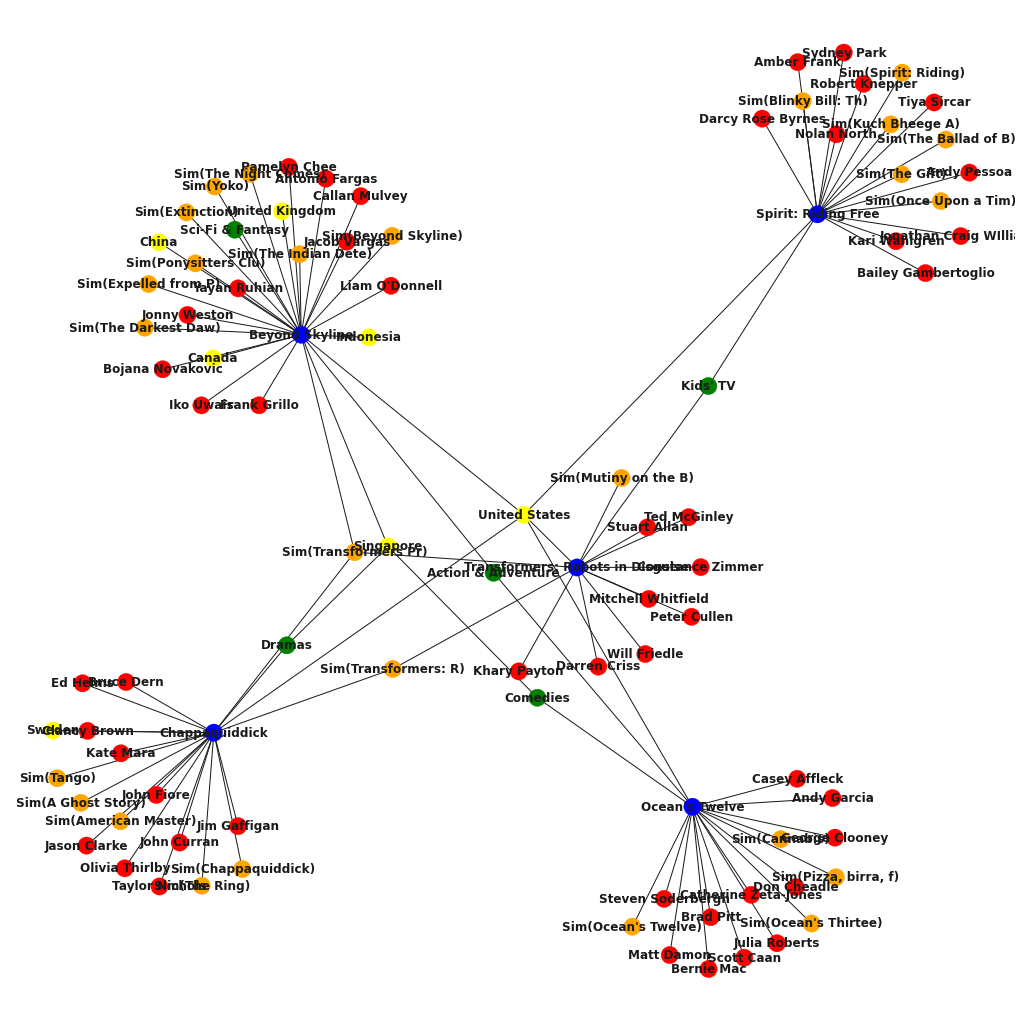

In [0]:
reco=list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

# **Movie Recommendation System**


we'll be building a baseline Movie Recommendation System
In this notebook, We will be implementing a few recommendation algorithms (content based, popularity based and collaborative filtering)  
> we have two MovieLens datasets.
* The First Dataset: Consists of 26,000,000 ratings and 750,
000 tag applications applied to 45,000 movies by 270,000 users. Includes data with 12 million relevance scores across 1,100 tags.
* The Second Dataset: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.


# Load the Data

In [0]:
df1=pd.read_csv('tmdb_5000_credits.csv')
df2=pd.read_csv('tmdb_5000_movies.csv')

## Train & Test the data

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [0]:
y=df1.id
x=df1.drop('id',axis=1)

In [0]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train.head()

,tittle,cast,crew
2208,Let Me In,"[{""cast_id"": 8, ""character"": ""Owen"", ""credit_i...","[{""credit_id"": ""54554defc3a3681473004dd8"", ""de..."
2709,Mr. Turner,"[{""cast_id"": 4, ""character"": ""JMW Turner"", ""cr...","[{""credit_id"": ""58f56ad4c3a3680e50005f41"", ""de..."
380,Cinderella Man,"[{""cast_id"": 1, ""character"": ""Jim Braddock"", ""...","[{""credit_id"": ""52fe428dc3a36847f8027913"", ""de..."
3078,Peaceful Warrior,"[{""cast_id"": 4, ""character"": ""Dan Millman"", ""c...","[{""credit_id"": ""52fe458c9251416c7505a4e5"", ""de..."
1467,The Age of Innocence,"[{""cast_id"": 1, ""character"": ""Newland Archer"",...","[{""credit_id"": ""52fe43709251416c750106c5"", ""de..."


In [0]:
x_train.shape

(3842, 3)

In [0]:
x_test.head()

,tittle,cast,crew
3616,Robin and Marian,"[{""cast_id"": 1, ""character"": ""Robin Hood"", ""cr...","[{""credit_id"": ""52fe43b79251416c7501b533"", ""de..."
3455,A Nightmare on Elm Street 5: The Dream Child,"[{""cast_id"": 1, ""character"": ""Freddy Krueger"",...","[{""credit_id"": ""52fe43389251416c7500813d"", ""de..."
1621,Dumb and Dumberer: When Harry Met Lloyd,"[{""cast_id"": 12, ""character"": ""Mrs. Dunne"", ""c...","[{""credit_id"": ""52fe43369251416c75007c47"", ""de..."
2615,Hoot,"[{""cast_id"": 5, ""character"": ""Delinko"", ""credi...","[{""credit_id"": ""584f79f09251416e48003c1b"", ""de..."
1892,The Losers,"[{""cast_id"": 3, ""character"": ""Franklin Clay"", ...","[{""credit_id"": ""52fe457e9251416c91034611"", ""de..."


In [0]:
x_test.shape

(961, 3)

# Demographic Filtering

 * They offer generalized recommendations to every user, based on movie genre or popularity. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too a simple recommender. 
 * The basic idea of this simple recommeder system is that movies which are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

* we need a metric to score/ rate movie
* Calculate the score for each movie
* Sort the scores to recommend the best rated movie to the users.
Mathematically, it is represented as follows:

Weighted Rating (WR) =  $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$
where,
* v is the number of votes for the movie
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie
* C is the mean vote across the whole report



Let's join the two dataset on the 'id' column

In [0]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

Just a look at our data.

In [0]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [0]:
C= df2['vote_average'].mean()
C

6.092171559442011

In [0]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

Now, we can filter out the movies that qualify

In [0]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

We can see there are 481 movies qualify to be in this list. we need to calculate our metric for each qualified movie.  we will define a function, weighted_rating(WR) and define a new feature score.

In [0]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [0]:
# Define a new feature 'score' and calculate its value with 'weighted_rating()'
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Now let's sort the DataFrame(DF) based on the score feature and output the title, vote counts, vote average and weighted rating or score of the top 10 movies.

In [0]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


# **Popularity Based Recommendation**

we find movies that are very popular and can be obtained by sorting the dataset by the popularity column.

Text(0.5, 1.0, 'Popular Movies')

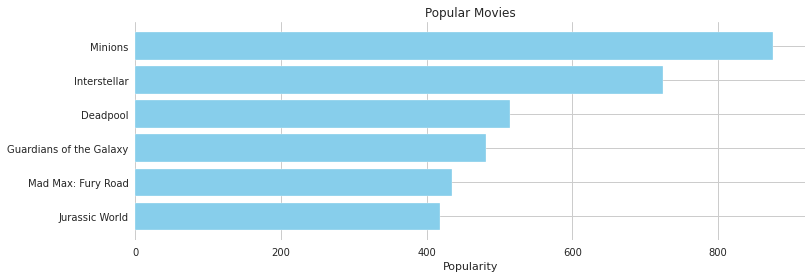

In [0]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Demographic recommender provide a general simple chart of recommended movies to all the users. They are not upto the mark of the interests and tastes of a particular user. So we move on to a more refined system- Content Basesd Filtering.

# **Content Based Filtering**

These filtering suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he/she will also like an item that is similar to it.

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. 

# **Plot description based Recommender**
We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. Let's take a look at the data...

In [0]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

we need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.
* Term frequency - it is the relative frequency of a word (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term(number of documents/documents with term) The overall importance of each word to the documents in which they present is equal to TF * IDF

- This provides a **matrix** where each column represents a word in the overview vocabulary and each row represents a movie.This is used to reduce the importance of words that occur frequently in plot overviews significance in computing the final similarity score.

Luckily scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix

In [0]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

we can now compute a similarity score. 

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies or Tv shows. We will use this cosine similarity score since it is independent of magnitude and is relatively easy and it is fast to calculate. 
- Mathematically, it is defined as follows:
cosine(x,y) = $\frac{x. y^\intercal}{||x||.||y||}$

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. so, we will use sklearn's linear_kernel() instead of cosine_similarities() because it is faster.

We see that over 20,000 different words were used to describe the 4800 movies in our dataset

In [0]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We need to define a function that takes in a movie title as  input and a list of the 10 most similar movies as outputs. Firstly, we need a mechanism to identify the index of a movie in our metadata DataFrame(DF), given its title.

In [0]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

We define our recommendation function. These are the following steps we will follow :-

* Get the index of the movie(title).
* Get the list of cosine similarity scores for the particular movie with all other movies. 
* Convert it into a list of tuples where the first element is its position and the second element is the similarity score.
* Sort the list of tuples based on the similarity scores;(the second element).
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [0]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [0]:
get_recommendations('Batman Forever')

3                         The Dark Knight Rises
119                               Batman Begins
65                              The Dark Knight
428                              Batman Returns
210                              Batman & Robin
3854    Batman: The Dark Knight Returns, Part 2
1359                                     Batman
4343                                   Cry_Wolf
174                         The Incredible Hulk
9            Batman v Superman: Dawn of Justice
Name: title, dtype: object

In [0]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

"Batman" returns all The Dark Knight Rises movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

# **Credits, Genres and Keywords Based Recommender**

We are going to build a recommender based on the following metadata: the top 3 actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords attributes, we need to extract the three most important actors, the director and the keywords associated with that movie. Our data is present in the form of "stringified" lists , we need to convert this into a safe and usable structured form.

In [0]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [0]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [0]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [0]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [0]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [0]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [0]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [0]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [0]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [0]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [0]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [0]:
get_recommendations('Catwoman', cosine_sim2)

4638    Amidst the Devil's Wings
3          The Dark Knight Rises
65               The Dark Knight
72                 Suicide Squad
119                Batman Begins
299               Batman Forever
468                    Swordfish
1043           Miss Congeniality
1456              Bound by Honor
210               Batman & Robin
Name: title, dtype: object

In [0]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

In [0]:
get_recommendations('Batman Forever').head(10)

3                         The Dark Knight Rises
119                               Batman Begins
65                              The Dark Knight
428                              Batman Returns
210                              Batman & Robin
3854    Batman: The Dark Knight Returns, Part 2
1359                                     Batman
4343                                   Cry_Wolf
174                         The Incredible Hulk
9            Batman v Superman: Dawn of Justice
Name: title, dtype: object

# **Collaborative Filtering**

**Single Value Decomposition**
SVD is a Scipy linear algebra function, Our goal is to predict unknown ratings. To handle the scalability and sparsity problem created by Collaborative Filtering is to leverage a latent factor model to grasp the similarity between users and items/products. Firstly, we need to turn the recommendation issue into an optimization problem. While predicting the rating for items/products given by a user we can see it as how good we are in. One regular metric is Root Mean Square Error (RMSE) we used to split the rating matrix into constituent user matrix with minimum sum. The less the RMSE, the better the performance.


In [0]:
pip install surprise

     |████████████████████████████████| 6.5MB 6.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1675383 sha256=39b9d3beb7a5b9ba22c3bc997e7f5950476fc871c8db03643e61bb0065c19709
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [0]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [0]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (4.732118844985962,
  4.680620908737183,
  4.757888317108154,
  4.661081790924072,
  4.734653949737549),
 'test_mae': array([0.6905478 , 0.69177064, 0.6862663 , 0.69156551, 0.68909435]),
 'test_rmse': array([0.8956906 , 0.89776436, 0.8897545 , 0.89788824, 0.89605277]),
 'test_time': (0.2946598529815674,
  0.14000391960144043,
  0.139481782913208,
  0.2784230709075928,
  0.13809919357299805)}

We get a mean Root Mean Sqaure Error of 0.89 approx which is more than good enough for our case. Let us now train on our dataset and arrive at predictions

In [0]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [0]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [0]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.746314978072187, details={'was_impossible': False})

For movie with ID 302, we got an estimated prediction of 2.746. One major feature of this recommender system is that it doesn't care what the movie is. It works on the basis of an provided movie ID and tries to predict ratings based on how the other users have predicted the movie.

# **Hybrid Filtering**

In [0]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [0]:
id_map = pd.read_csv(r'links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(df2[['title', 'id']], on='id').set_index('title')

In [0]:
indices_map = id_map.set_index('id')

In [0]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = df2.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [0]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,id,est
634,The Matrix,8907,7.9,603,3.193289
2967,E.T. the Extra-Terrestrial,3269,7.3,601,2.952476
1784,Ever After: A Cinderella Story,399,6.8,9454,2.941855
2130,The American,481,5.8,27579,2.818593
2875,Two Lovers,154,6.6,10362,2.815604
570,Ransom,470,6.4,3595,2.675774
3604,Apollo 18,356,5.0,50357,2.657691
1274,Just Visiting,171,4.8,56715,2.657691
3724,Falcon Rising,71,5.5,270938,2.657691
4211,Mississippi Mermaid,32,6.7,1651,2.657691


# **Conclusion**
We created recommenders using demographic , content- based and collaborative filtering. Hybrid Systems can take advantage of content-based and collaborative filtering as the two models are proved to be almost complimentary. so we implemented hybrid recommender also.